# 01 - Continuous stirred tank reactor (CSTR)

**Amazon SageMaker kernel**: conda_pytorch_p36

## Process description

The continuous stirred tank reactor (CSTR) is a common model for a chemical reactor in chemical engineering that assumes perfect mixing. Therefore, the output composition is identical to the composition of the material inside the reactor, which is a function of the residence time and the reaction rate.

<img src="continuous-stirred-tank-reactor.png" alt="CSTR drawing" style="width: 300px;"/>

The process has four states: concentration of reactant A ($C_A$), concentration of reactant B ($C_B$), temperature in the reactor ($T_R$), and temperature in the cooling jacket ($T_K$). There are two inputs (set points) in the system: feed flow rate ($F$) and heat flux ($\dot{Q}$). This reactor receives reactant A and releases a solution that contains both reactant A and B with concentrations $C_A$ and $C_B$.

The objective for a process engineer is to find **optimal set points** ($F$ and $\dot{Q}$) that will produce a mixture with **desired concentration** of B $C_B$, while **preserving safe operating conditions** for the cooling jacket, i.e., 50 [C] $\le T_K \le$ 140 [C].

## Historical data set

You already have historical data from an industrial data lake (similar to the one you built in the first part of the workshop). Measurements have been consolidated into a single csv file for easy consumption. The data set is loaded into a `pandas` dataframe.

In [1]:
import os
import pandas as pd

FILE_PATH = os.path.join(os.getcwd(), "data", "historical", "measurements.csv")

df = pd.read_csv(FILE_PATH)
df.head()

,F,Q_dot,C_a,C_b,T_R,T_K
0,88.89,-2867.2,2.5949,1.0919,138.5,134.9
1,6.36,-2749.2,0.7418,0.6344,127.9,124.8
2,30.09,-629.2,1.2907,0.9109,141.5,141.0
3,93.43,-2647.9,2.6380,1.0643,138.8,135.2
4,50.05,-475.9,1.7665,1.0908,141.5,140.5


The first step will be the exploration of the data set in search for insight into the process dynamics. From these plots we can observe that:

- When $F$ increases $C_A$ increases
- Temperatures $T_R$ and $T_K$ are positively correlated
- $C_B$ increases when $C_A$ increases until it plateaus

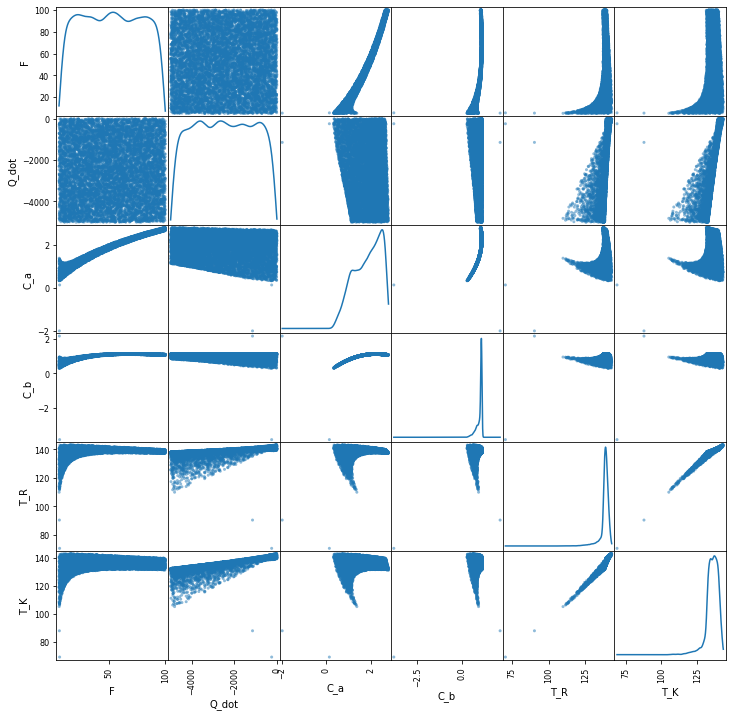

In [2]:
import matplotlib.pyplot as plt

pd.plotting.scatter_matrix(df, figsize=(12,12), diagonal='kde')
plt.show()

## Building a process model

Historical data will now be used to build a machine learning model of the reactor dynamics. The following cell shows the script of that defined a process model designed in PyTorch, an open source machine learning framework. The model will take two inputs (`F` and `Q_dot`) and will return three outputs (`C_a`, `C_b`, and `T_K`).

Spend a minute exploring the structure of the multi layer perceptron model that is used to predict the behavior of the CSTR process.

In [3]:
!pygmentize CSTRModel.py

import torch
import torch.nn as nn

class CSTRModel(torch.nn.Module):
    """
    MLP model for the CSTR forward model
    """

    def __init__(self):
        super(CSTRModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 3),
        )

    def forward(self, x):
        y_pred = self.linear_relu_stack(x)
        return y_pred


Before training the model, historical data will be split into a training and a validation set, which will have 90% and 10% of the data, respectively.

In [4]:
import numpy as np

model_data = df[["C_a", "C_b", "T_K", "F", "Q_dot"]]
train_data, validation_data = np.split(
    model_data.sample(frac=1, random_state=42),
    [int(0.9 * len(model_data))])

The `process_dataframe` function scales input and output variables before training the `CSTRModel` to improve training.

In [5]:
import torch

def process_dataframe(df):
    """
    Preprocess a pandas dataframe to extract
    independent and depent variables, and scale them
    """
    X = df[['F', 'Q_dot']].values
    Y = df[['C_a', 'C_b', 'T_K']].values
    # Scale F between 5 and 100
    X[:,0] = (X[:,0]-5.0)/95.0
    # Scale Q_dot between -5000 and 0
    X[:,1] = (X[:,1]+5000.0)/5000.0
    # Scale T_K between 125.0 and 150.0
    Y[:,2] = (Y[:,2]-125.0)/25.0
    # Convert to PyTorch tensors
    X = torch.from_numpy(X.astype(np.float32))
    Y = torch.from_numpy(Y.astype(np.float32))
    
    return (X, Y)

X_train, Y_train = process_dataframe(train_data)
X_validation, Y_validation = process_dataframe(validation_data)

We will now select a learning rate, a loss function, and an optimizer. In this case we will use the Adam optimizer with a learning rate of 0.0025

In [6]:
from CSTRModel import CSTRModel
import torch.nn as nn

model = CSTRModel()
learning_rate = 0.0005
l = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr =learning_rate)

Now we train the model. The model is small and it should only take 1 to 2 minutes to train.

Model training took 81.8 seconds


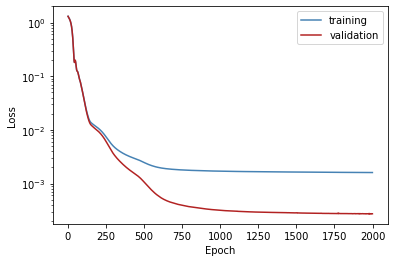

In [7]:
import matplotlib.pyplot as plt
import timeit

num_epochs = 2000
training_loss, validation_loss = [], []

tic=timeit.default_timer()
for epoch in range(num_epochs):
    # Forward feed
    Y_pred = model(X_train.requires_grad_())
    # Calculate the training loss
    t_loss = l(Y_pred, Y_train)
    training_loss.append(t_loss.item())
    # Calculate validation loss
    Y_pred = model(X_validation)
    v_loss = l(Y_pred, Y_validation)
    validation_loss.append(v_loss.item())
    # Backpropagation: calculate gradients
    t_loss.backward()
    # Update the weights
    optimizer.step()
    # Clear out the gradients from the last step loss.backward()
    optimizer.zero_grad()

toc=timeit.default_timer()

print("Model training took {:.1f} seconds".format(toc-tic))

# Plot training and validation losses
plt.plot(training_loss, color="steelblue", label="training")
plt.plot(validation_loss, color="firebrick", label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss"); plt.yscale('log')
plt.legend()

plt.show()

### Evaluate process model

We now can evaluate the `CSTRModel` with various conditions (i.e., different combinations of `F` and `Q_dot`) and compare them to historical data. One quick evaluation we can conduct is to evaluate the model for the same condition simulated with the `steady_state_cstr` model, i.e., $F$ = 12.0 [l/h] and $\dot{Q}$ = -10.0 [kW].

In [8]:
def evaluate_pytorch_model(model, manipulated_vars):
    """
    Return prediction for a set of manipulated variables
    """
    X_test = manipulated_vars[["F", "Q_dot"]].values
    X_test[:,0] = (X_test[:,0]-5.0)/95.0
    X_test[:,1] = (X_test[:,1]+5000.0)/5000.0
    X_test = torch.from_numpy(X_test.astype(np.float32))
    Y_test = model(X_test.float()).cpu().detach().numpy()
    Y_test[:,2] = (Y_test[:,2]*25.0)+125.0
    prediction = pd.DataFrame({"F" : manipulated_vars["F"].values.round(2),
                              "Q_dot": manipulated_vars["Q_dot"].values.round(1),
                              "C_a": Y_test[:,0].round(4),
                              "C_b": Y_test[:,1].round(4),
                              "T_K": Y_test[:,2].round(1)})
    
    return prediction

In [9]:
manipulated_vars = pd.DataFrame({"F": [12.0], "Q_dot": [-10.0]})

prediction = evaluate_pytorch_model(model, manipulated_vars)
measurements = prediction.loc[0,:]

print("Measurements from CSTR:")
print("Flow rate: {:.2f} l/h".format(measurements["F"]))
print("Concentration of reactant A: {:.4f} mol A/l".format(measurements["C_a"]))
print("Concentration of reactant B: {:.4f} mol B/l".format(measurements["C_b"]))
print("Temperature in the cooling jacket: {:.2f} C".format(measurements["T_K"]))

Measurements from CSTR:
Flow rate: 12.00 l/h
Concentration of reactant A: 0.6048 mol A/l
Concentration of reactant B: 0.5035 mol B/l
Temperature in the cooling jacket: 142.40 C


Now we will persist the model so it can be reused without having to retrain it. The model will be put inside a TGZ file and uploaded to an S3 bucket so we can deploy it to the edge device later.

In [10]:
import tarfile
import os

# Trace the whole module (class) and construct a ScriptModule with a single forward method
module = torch.jit.trace(model.float().eval(), torch.rand(1,2).float())
module.save("cstr.pth")
model_name = "cstr-model"

try:
    os.remove("{:s}.tar.gz".format(model_name))
except:
    pass

with tarfile.open("{:s}.tar.gz".format(model_name), "w:gz") as f:
    f.add("cstr.pth")

In [11]:
import boto3
import sagemaker
import time
from sagemaker.utils import name_from_base

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = "us-east-1" #<<AWS region>>
bucket = "sagemaker-data-bucket-6835" # <<Bucket from CloudFormation template>>
prefix = "models/pytorch"

model_path = sess.upload_data(path="{:s}.tar.gz".format(model_name), bucket = bucket, key_prefix=prefix)
model_s3_uri = "s3://{:s}/{:s}/{:s}.tar.gz".format(bucket, prefix, model_name)
print("The model tarball is available at: ", model_s3_uri)

The model tarball is available at:  s3://sagemaker-data-bucket-6835/models/pytorch/cstr-model.tar.gz


## Process maps

One approach to explore the behavior of a forward model is through a **process map**, which leverages our model to predict controlled variables for different combinations of manipulated variables. We will construct a grid of combinations of manipulated variables and use our model to predict the expected behavior of the CSTR.

In [12]:
import numpy as np

# Construct grid
n_x, n_y = 100, 100
F_1d = np.linspace(5.0, 100.0, n_x)
Q_dot_1d = np.linspace(-5000.0, 0.0, n_y)

F_2d, Q_dot_2d = np.meshgrid(F_1d, Q_dot_1d)

map_df = pd.DataFrame({"F": F_2d.flatten(),
                      "Q_dot": Q_dot_2d.flatten()})
map_pred = evaluate_pytorch_model(model, map_df)

C_a_2d = map_pred["C_a"].values.reshape(n_x, n_y)
C_b_2d = map_pred["C_b"].values.reshape(n_x, n_y)
T_K_2d = map_pred["T_K"].values.reshape(n_x, n_y)

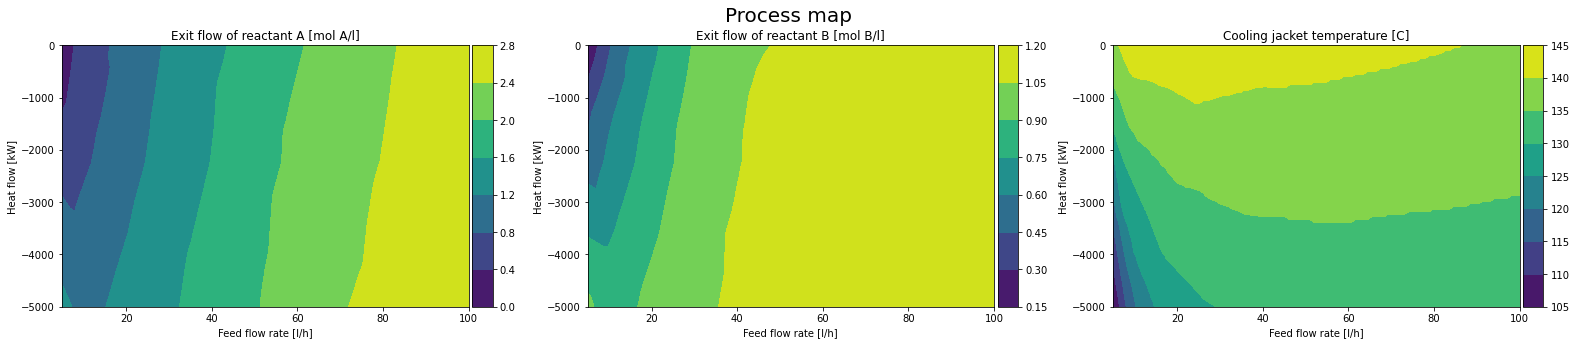

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(22, 5))
# Plot concentration of reactant A [mol A/l]
ax1 = fig.add_subplot(1,3,1)
im1 = ax1.contourf(F_2d, Q_dot_2d, C_a_2d)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_xlabel("Feed flow rate [l/h]")
ax1.set_ylabel("Heat flow [kW]")
ax1.title.set_text("Exit flow of reactant A [mol A/l]")

# Plot concentration of reactant B [mol B/l]
ax2 = fig.add_subplot(1,3,2)
im2 = ax2.contourf(F_2d, Q_dot_2d, C_b_2d)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')
ax2.set_xlabel("Feed flow rate [l/h]")
ax2.set_ylabel("Heat flow [kW]")
ax2.title.set_text("Exit flow of reactant B [mol B/l]")

# Plot reactor temperature [C]
ax3 = fig.add_subplot(1,3,3)
im3 = ax3.contourf(F_2d, Q_dot_2d, T_K_2d)
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')
ax3.set_xlabel("Feed flow rate [l/h]")
ax3.set_ylabel("Heat flow [kW]")
ax3.title.set_text("Cooling jacket temperature [C]")

fig.suptitle("Process map", fontsize=20, y=0.95)
fig.tight_layout()

plt.show()

## Process optimization

The first use of the process model `model` will be to help with process optimization by selecting the inputs that are likely to result in desired behavior. Let us consider the case when the process engineer would like to achieve a desired $C_B^{*}$ at the output of the CSTR, while satisfying safety condition (soft constraints)

$$
50.0 [C] \le T_K \le 140.0 [C]
$$

and the admissible ranges for the manipulated variables (hard constraints)

$$
5 [l/h] \le F \le 100.0 [l/h] \\
-5000.0 [kW] \le \dot{Q} \le 0.0 [kW]
$$

In this example we will use the `dual_annealing` function for `scipy` to find optimal manipulated variables.

In [14]:
from scipy.optimize import dual_annealing
import pandas as pd
import numpy as np
import timeit

def optimal_manipulated_vars(C_b_ref):
    """
    Drive CSTR toward C_b_ref
    """
    C_b_ref = C_b_ref
    # Admissible bounds for manipulated variables
    bounds = ((5.0, 100.0), (-5000.0, 0.0))
    
    def objective(x):
        '''
        Objective function to minimize: Penalizes deviations from
        C_b_ref and T_K leaving the desired range
        '''
        manipulated_vars = pd.DataFrame({"F": [x[0]], "Q_dot" : [x[1]]})
        prediction = evaluate_pytorch_model(model, manipulated_vars)
        cost = 0.0
        # Deviation from reference C_b_ref
        cost += (prediction["C_b"][0]-C_b_ref)**2
        # Cooling jacket temperature
        if (prediction["T_K"][0] < 5.0):
            cost += 0.01*(prediction["T_K"][0]-5.0)**2
        elif (prediction["T_K"][0] > 140.0):
            cost += 0.01*(prediction["T_K"][0]-140.0)**2

        return cost
    tic=timeit.default_timer()
    result = dual_annealing(objective, bounds=bounds, maxiter=2000)
    toc=timeit.default_timer()
    
    return (result['x'], result['nfev'], toc-tic)

We can evaluate the optimization function and calculate the optimal manipulated variables to reach $C_B$ = 0.6 [mol/l], while staying within the bounds for flow rate, heat rate, and cooling jacket temperature.

In [15]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

# Find optimal conditions to drive CSTR to 0.6 [mol/l]
x, nfev, elapsed_time = optimal_manipulated_vars(0.6)

# Summarize the result
print('Total Evaluations: {:d}'.format(nfev))
# Evaluate solution
print("The optimal feed flow rate is {:.1f} [l/h]".format(x[0]))
print("The optimal heat flux is {:.0f} [kW]".format(x[1]))
controlled_vars = evaluate_pytorch_model(model, pd.DataFrame({"F": [x[0]], "Q_dot": [x[1]]}))
print("The predicted concentration of B is {:.4f} [mol/l]".format(controlled_vars["C_b"][0]))
print("The cooling jacket temperature was {:.1f} [C]".format(controlled_vars["T_K"][0]))
print("Optimization took {:.1f} seconds".format(elapsed_time))

Total Evaluations: 9382
The optimal feed flow rate is 6.0 [l/h]
The optimal heat flux is -2698 [kW]
The predicted concentration of B is 0.6000 [mol/l]
The cooling jacket temperature was 124.2 [C]
Optimization took 23.8 seconds


### (OPTIONAL) Surrogate model for process optimization

The optimization routine took approximately 30 seconds to run. This process could be sped up with a more careful design of a wrapper and the choice of a different solver, but it is unlikely to reach the near-real time processing requirements that are found in some industrial processes. This process can be sped up with the use of a surrogate model of the optimization problem (i.e., a model that learns to mimic the behavior of the optimizer). This is a model that takes as the input the desired concentration of reactant B at the end of the process ($C_B$) and returns the feed flow rate ($F$) and heat flux ($\dot{Q}$) that are likely to take the reactor to reach desired conditions, without violating any of the process constraints.

In [16]:
generate_surrogate_model_data = False
FILE_PATH = os.path.join(os.getcwd(), "data", "optimization", "optimization.csv")

if generate_surrogate_model_data:
    # Initialize lists
    C_b_ls, F_ls, Q_dot_ls = [], [], []
    # Generate training data for the surrogate model
    for C_b in np.arange(start=0.0, stop=1.2, step=0.01):
        x, nfev, elapsed_time = optimal_manipulated_vars(C_b)
        C_b_ls.append(C_b)
        F_ls.append(x[0])
        Q_dot_ls.append(x[1])
    df = pd.DataFrame({"C_b": C_b_ls, "F": F_ls, "Q_dot": Q_dot_ls})
    df.to_csv(FILE_PATH, index=False)
else:
    df = pd.read_csv(FILE_PATH)

df.head()

,C_b,F,Q_dot
0,0.00,5.001071,-234.271732
1,0.01,5.000170,-235.000375
2,0.02,5.000690,-234.775694
3,0.03,5.000645,-234.993023
4,0.04,5.001174,-234.808592


The dataframe `df` has been pre-loaded with the behavior of the optimization problem described at the beginning of the notebook. We can use the data to get the optimal set points of the tank reactor without having to call the optimization problem again.

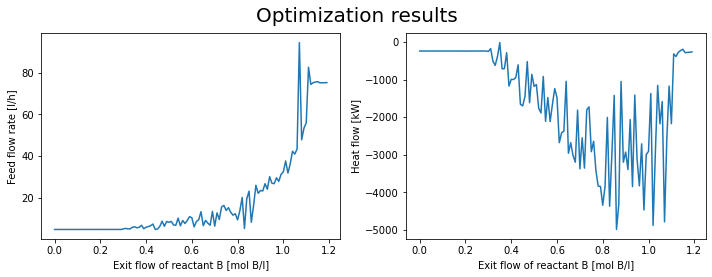

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 4))
# Predict feed flow rate
ax1 = fig.add_subplot(1,2,1)
im1 = ax1.plot(df["C_b"], df["F"])
ax1.set_xlabel("Exit flow of reactant B [mol B/l]")
ax1.set_ylabel("Feed flow rate [l/h]")

# Plot concentration of reactant B [mol B/l]
ax2 = fig.add_subplot(1,2,2)
im2 = ax2.plot(df["C_b"], df["Q_dot"])
ax2.set_xlabel("Exit flow of reactant B [mol B/l]")
ax2.set_ylabel("Heat flow [kW]")

fig.suptitle("Optimization results", fontsize=20, y=0.95)
fig.tight_layout()

plt.show()

The process shown above to build a machine learning model with PyTorch can be repeated with the optimization results. In this process we are creating a surrogate model that we can easily compile and export to the edge device, and that will approximate optimal inputs in **a fraction of a second**.

In [19]:
import numpy as np
import torch

model_data = df[["F", "C_b", "Q_dot"]]
train_data, validation_data = np.split( model_data.sample(frac=1, random_state=42), [int(0.9 * len(model_data))])

def process_dataframe(df):
    """
    Preprocess a pandas dataframe to extract
    independent and depent variables, and scale them
    """
    X = df[['C_b']].values
    Y = df[['F', 'Q_dot']].values
    # Scale F between 5 and 100
    Y[:,0] = (Y[:,0]-5.0)/95.0
    # Scale Q_dot between -5000 and 0
    Y[:,1] = (Y[:,1]+5000.0)/5000.0
    # Convert to PyTorch tensors
    X = torch.from_numpy(X.astype(np.float32))
    Y = torch.from_numpy(Y.astype(np.float32))
    
    return (X, Y)

X_train, Y_train = process_dataframe(train_data)
X_validation, Y_validation = process_dataframe(validation_data)

Model training took 3.2 seconds


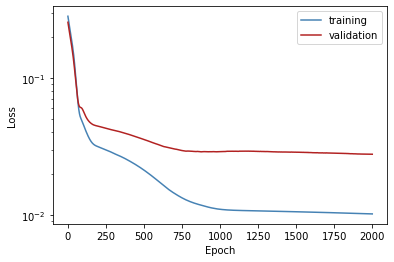

In [20]:
from CSTROptimizer import CSTROptimizer
import torch.nn as nn
import matplotlib.pyplot as plt
import timeit

model = CSTROptimizer()
learning_rate = 0.0005
l = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr =learning_rate)

num_epochs = 2000
training_loss, validation_loss = [], []

tic=timeit.default_timer()
for epoch in range(num_epochs):
    # Forward feed
    Y_pred = model(X_train.requires_grad_())
    # Calculate the training loss
    t_loss = l(Y_pred, Y_train)
    training_loss.append(t_loss.item())
    # Calculate validation loss
    Y_pred = model(X_validation)
    v_loss = l(Y_pred, Y_validation)
    validation_loss.append(v_loss.item())
    # Backpropagation: calculate gradients
    t_loss.backward()
    # Update the weights
    optimizer.step()
    # Clear out the gradients from the last step loss.backward()
    optimizer.zero_grad()

toc=timeit.default_timer()

print("Model training took {:.1f} seconds".format(toc-tic))

# Plot training and validation losses
plt.plot(training_loss, color="steelblue", label="training")
plt.plot(validation_loss, color="firebrick", label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss"); plt.yscale('log')
plt.legend()

plt.show()

Now that the surrogate model has been trained we can persist it in a TGZ file and upload it to an S3 bucket following the same process that we used with the process model.

In [21]:
import tarfile
import os

# Trace the whole module (class) and construct a ScriptModule with a single forward method
module = torch.jit.trace(model.float().eval(), torch.rand(1,1).float())
module.save("cstr-optimizer.pth")
model_name = "cstr-optimizer"

try:
    os.remove("{:s}.tar.gz".format(model_name))
except:
    pass

with tarfile.open("{:s}.tar.gz".format(model_name), "w:gz") as f:
    f.add("cstr-optimizer.pth")

In [22]:
import boto3
import sagemaker
import time
from sagemaker.utils import name_from_base

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = "us-east-1" #<<AWS region>>
bucket = "sagemaker-data-bucket-6835" # <<Bucket from CloudFormation template>>
prefix = "models/pytorch"

model_path = sess.upload_data(path="{:s}.tar.gz".format(model_name), bucket = bucket, key_prefix=prefix)
model_s3_uri = "s3://{:s}/{:s}/{:s}.tar.gz".format(bucket, prefix, model_name)
print("The model tarball is available at: ", model_s3_uri)

The model tarball is available at:  s3://sagemaker-data-bucket-6835/models/pytorch/cstr-optimizer.tar.gz
